In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=UserWarning) 

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [2]:
smarts = {'alkane':'[CX4;H0,H1,H2,H4]',
                   'methyl':'[CH3]',
                   'alkene':'[CX3]=[CX3]',
                   'alkyne':'[CX2]#C',
                   'alcohols':'[#6][OX2H]',
                   'amines':'[NX3;H2,H1;!$(NC=O)]', 
                   'nitriles':'[NX1]#[CX2]', 
                   'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
                   'alkyl halides':'[#6][F,Cl,Br,I]', 
                   'esters':'[#6][CX3](=O)[OX2H0][#6]', 
                   'ketones':'[#6][CX3](=O)[#6]',
                   'aldehydes':'[CX3H1](=O)[#6]', 
                   'carboxylic acids':'[CX3](=O)[OX2H1]', 
                   'ether': '[OD2]([#6])[#6]',
                   'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
                   'amides':'[NX3][CX3](=[OX1])[#6]',
                   'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]',
                   'heterocyclic': '[!#6;!R0]',
                   'aryl chlorides': '[Cl][c]',
                   'carboxylic esters': '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[OX2][#6;!$(C=[O,N,S])]',
                   'alkyl aryl ethers': '[OX2](c)[CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])]',
                   'phenols': '[OX2H][c]'}

func_group_names = pd.Series(smarts.keys())
func_group_names

0                alkane
1                methyl
2                alkene
3                alkyne
4              alcohols
5                amines
6              nitriles
7             aromatics
8         alkyl halides
9                esters
10              ketones
11            aldehydes
12     carboxylic acids
13                ether
14         acyl halides
15               amides
16                nitro
17         heterocyclic
18       aryl chlorides
19    carboxylic esters
20    alkyl aryl ethers
21              phenols
dtype: object

In [3]:
class FunctionalGroupsDataset(Dataset):
    '''
    PyTorch compatible dataset of functional groups files

    Parameters
    ----------

    func_group : str
        Name of the functional group to retrieve data from.
    
    convert_to : str, default None
        Converts all data to specified data type.

    '''
    def __init__(self, func_group: str, convert_to: str = None) -> None:
        self.convert_to = convert_to
        self.func_group_number = np.where(func_group_names.values == func_group)[0][0]
        self.main_dir = os.path.join('..', 'ALL')
        self.func_group = func_group

        #NIST IDs that passed preprocessing
        preprocessed_data_dir = pd.DataFrame(os.listdir(os.path.join(self.main_dir, 'preprocessed_data')))


        if func_group not in os.listdir(os.path.join(self.main_dir, 'functional_groups')):
            raise ValueError(f'{func_group} is not present in our database.')
        else:
            #All NIST IDs of specific functional group
            func_group_data_dir = pd.DataFrame(os.listdir(os.path.join(self.main_dir, 'functional_groups', func_group)))

        #NIST IDs of specific functional group that passed preprocessing
        to_sample = pd.merge(preprocessed_data_dir, func_group_data_dir, on = [0, 0], how = 'outer', indicator = True).query('_merge=="left_only"')[0]

        #Equinumerous dataset of preprocessed functional group NIST IDs and shuffled from every other functional groups
        if len(to_sample) < len(func_group_data_dir):
            func_group_data_dir = func_group_data_dir.sample(len(to_sample))
            self.data = pd.concat([to_sample.sample(len(to_sample)), func_group_data_dir], axis = 0)
        else:
            self.data = pd.concat([to_sample.sample(len(func_group_data_dir)), func_group_data_dir], axis = 0)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        file_path = os.path.join(self.main_dir, 'preprocessed_data', self.data.iloc[index][0])
        file = pd.read_csv(file_path)
        spectra_type = file['spectraType'][0]



        #Converts data
        if not self.convert_to:
            spectra = torch.nan_to_num(torch.tensor(file['y'].values, requires_grad=True)).to(torch.float)

        elif self.convert_to.lower() not in ('absorbance', 'absorbancja', 'transmittance', 'transmitancja'):
            raise ValueError(f'Cant convert to {self.convert_to}.')

        elif self.convert_to.lower() != str(spectra_type).lower():
            spectra = torch.nan_to_num(torch.tensor(np.abs(1 - file['y'].values), requires_grad=True)).to(torch.float)
        
        else:
            spectra = torch.nan_to_num(torch.tensor(file['y'].values, requires_grad=True)).to(torch.float)

        #Reshapes it as required
        spectra = spectra.reshape(1, 1, 3106)
        
        #Prevents unknown problem with NaN from before
        func_group = torch.nan_to_num(torch.tensor(file['funcGroups'].values[self.func_group_number], requires_grad=True)).to(torch.float)

        return spectra, func_group

In [4]:
func_groups_path = os.path.join('..', 'ALL', 'functional_groups')
func_groups_path

'../ALL/functional_groups'

In [5]:
#Creates hashmaps where data is further retrieved by functional group name and its whether its training or test set

def createHashmaps(test_ratio: float = 0.3,
                    batch_size: int = 128):
    
    '''
    Creates hashmaps containing FTIR data.

    Parameters
    ----------

    test_ratio : float, default 0.3
        Ratio of test dataset.
    
    batch_size : int, default 128
        Size of the batch.
    '''

    func_groups_data, func_groups_datasets, func_groups_dataloaders = {}, {}, {}
    for data_directory in os.listdir(func_groups_path):
        dataset = FunctionalGroupsDataset(data_directory, convert_to = 'absorbance')

        training_dataset, test_dataset = random_split(dataset, [1 - test_ratio, test_ratio], torch.Generator())

        func_groups_dataloaders[data_directory] = {'training': DataLoader(training_dataset, batch_size = batch_size, shuffle = True), 'test' : DataLoader(test_dataset, batch_size = batch_size, shuffle = False)}

    return func_groups_data, func_groups_datasets, func_groups_dataloaders

In [6]:
func_groups_data, func_groups_datasets, func_groups_dataloaders = createHashmaps()

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
class CNN(torch.nn.Module):
    '''
    Functional groups recognition CNN model.
    '''
    def __init__(self) -> None:
        super(CNN, self).__init__()

        kernel_size_1 = 5
        stride_conv_1 = 1

        stride_pool_1 = 3
        filter_size_1 = 3

        num_out_3 = 20
        num_out_4 = 10

        self.conv_1 = torch.nn.Conv1d(1, 10, kernel_size = kernel_size_1, stride = stride_conv_1)

        self.pool_1 = torch.nn.MaxPool1d(filter_size_1, stride_pool_1)

        self.conv_2 = torch.nn.Conv1d(10, 10, kernel_size = kernel_size_1, stride = stride_conv_1)

        self.pool_2 = torch.nn.MaxPool1d(filter_size_1, stride_pool_1)

        self.conv_3 = torch.nn.Conv1d(10, 10, kernel_size = kernel_size_1, stride = stride_conv_1)

        self.pool_3 = torch.nn.MaxPool1d(filter_size_1, stride_pool_1)



        self.linear_1 = torch.nn.Linear(1130, num_out_3)

        self.linear_2 = torch.nn.Linear(num_out_3, num_out_4)

        self.linear_out = torch.nn.Linear(num_out_4, 1)


    def forward(self, x):
        bs, c, h, w = x.shape
        x = x.reshape(bs, c, h * w)
        out = self.conv_1(x)
        out = F.tanh(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.tanh(out)
        out = self.pool_2(out)
        
        out = self.conv_3(out)
        out = F.tanh(out)
        out = self.pool_3(out)


        out = out.reshape(x.shape[0], 1, out.shape[2] * out.shape[1])

        
        out = self.linear_1(out)
        out = F.leaky_relu(out)

        out = self.linear_2(out)
        out = F.selu(out)

        out = self.linear_out(out)
        out = F.sigmoid(out)

        return out.squeeze(1)

    
def train(num_epochs: int, 
          loss_func, 
          group: str,
          data_loaders: dict,
          weight_decay: float,
          lambda_lr: float,
          learning_rate: float = 1e-6, 
          seed: int = 42, 
          plot: bool = False,
          save: bool = False, 
          disable_verbose: bool = False,
          iter: int = 0, 
          save_dirpath: str|os.PathLike|bytes = None) -> CNN:

    '''
    Training of the functional groups finding CNN model

    Parameters
    ----------

    num_epochs : int
        Number of epochs for model learning.
    
    loss_func : Any
        Loss function.

    group : str
        Name of functional group.

    data_loaders : dict
        Data loaders hashmap object.

    weight_decay : float
        Weight decay coefficient.

    lambda_lr: float
        A multiplicative factor for lambda function.

    learning_rate : float, default 1e-6
        Models starting learning rate.

    seed : int, default 42
        Seed for random number generator for replicability.

    plot : bool, default False
        If True then shows the loss plot.

    save : bool, default False
        If True then saves the loss plot.

    disable_verbose : bool, default False
        Whether to disable the entire progressbar wrapper.

    iter : int, default 0
        Number of model testing iteration.

    save_dirpath : str|os.PathLike|bytes, default None
        Directory path to save the plot.
    '''

    train_losses, test_losses = [], []


    model = CNN().to(device)

    torch.manual_seed(seed)

    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    scheduler = LambdaLR(optimizer, lr_lambda = lambda epoch: lambda_lr ** epoch)


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.
        with tqdm(data_loaders[group]['training'], disable=disable_verbose) as pbar:
            f1 = 0
            predicted_well_count = np.zeros(1)
            all_func_groups_count = np.zeros(1)
            for y_batch, func_group_batch in pbar:
                y_batch, func_group_batch = y_batch.to(device), func_group_batch.to(device)

                optimizer.zero_grad()
                output = model(y_batch).squeeze(1)
                loss = loss_func(output, func_group_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                for i in range(output.shape[0]):
                    #Counts well predicted functional groups
                    predicted_well = ((torch.round(output[i]) == func_group_batch[i]) * 1 * func_group_batch[i]).item()
                    predicted_well_count += predicted_well
                    all_func_groups_count += func_group_batch[i].item()

                f1 = metrics.f1_score(torch.Tensor.cpu(func_group_batch).detach().numpy(), torch.Tensor.cpu(torch.round(output)).detach().numpy())
                pbar.set_postfix(epoch = epoch, loss = train_loss, accuracy = (predicted_well_count/all_func_groups_count).item(), f1 = f1, lr = optimizer.param_groups[0]['lr'])

            train_loss /= len(data_loaders[group]['training'])
            train_losses.append(train_loss)


        model.eval()
        test_loss = 0.

        with torch.no_grad():
            with tqdm(data_loaders[group]['test'], disable = disable_verbose) as tbar:
                f1 = 0
                predicted_well_count = np.zeros(1)
                all_func_groups_count = np.zeros(1)
                for y_batch, func_group_batch in tbar:
                    y_batch, func_group_batch = y_batch.to(device), func_group_batch.to(device)

                    output = model(y_batch).squeeze(1)
                    loss = loss_func(output, func_group_batch)
                    test_loss += loss.item()

                    for i in range(output.shape[0]):
                        predicted_well = ((torch.round(output[i]) == func_group_batch[i]) * 1 * func_group_batch[i]).item()
                        predicted_well_count += predicted_well
                        all_func_groups_count += func_group_batch[i].item()

                    f1 = metrics.f1_score(torch.Tensor.cpu(func_group_batch).detach().numpy(), torch.Tensor.cpu(torch.round(output)).detach().numpy())
                    tbar.set_postfix(epoch = epoch, loss = test_loss, accuracy = (predicted_well_count/all_func_groups_count).item(), f1 = f1)

                
                test_loss /= len(data_loaders[group]['test'])
                test_losses.append(test_loss)

        scheduler.step()
        


    if plot:
        plt.plot(train_losses, label='training loss')
        plt.plot(test_losses, label='test loss')
        plt.legend()
        plt.title(f'{group}')
        plt.plot()
        plt.show()
    
    if save:
        plt.savefig(os.path.join(save_dirpath, f"Learning_progress_{group}_{str(iter)}.png"))

    return model

In [9]:
def trainingMetrics(model: CNN, 
                 group: str,
                 data_loaders: dict,
                 iter: int = 0,
                 save_dirpath: str|os.PathLike|bytes = None) -> pd.DataFrame:
    
    '''
    Counts training metrics of the model.

    Parameters
    ----------

    model : CNN
        Model object to see the perfomance of.

    group : str
        Name of functional group.

    data_loaders : dict
        Data loaders hashmap object.

    iter : int, default 0
        Number of model testing iteration.

    save_dirpath : str|os.PathLike|bytes, default None
        Directory path to save the plot.
    '''

    model.eval()
    actual = []
    pred = []
    with torch.no_grad():
        predicted_well_count = np.zeros(1)
        all_func_groups_count = np.zeros(1)

        for y_batch, func_group in data_loaders[group]['training']:
            y_batch, func_group = y_batch.to(device), func_group.to(device)

            outputs = model(y_batch)
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            func_group = torch.Tensor.cpu(func_group).detach().numpy()

            pred.extend(outputs.reshape(-1).round())
            actual.extend(func_group.reshape(-1))

            for i in range(outputs.shape[0]):
                predicted_well = (np.round(outputs[i]) == func_group[i]) * 1 * func_group[i]
                    
                predicted_well_count += predicted_well
                all_func_groups_count += func_group[i]

        df = pd.concat(
            [
                pd.DataFrame([group]), 
                pd.DataFrame(predicted_well_count / all_func_groups_count), 
                pd.DataFrame(predicted_well_count), 
                pd.DataFrame(all_func_groups_count)
            ], 
            axis = 1, 
            ignore_index = True)
        df.columns = ['funcGroup', 'prediction acc', 'predicted well', 'number of groups']

        confusion_matrix = metrics.confusion_matrix(actual, pred)

        true_negative = confusion_matrix[0][0]
        true_positive = confusion_matrix[1][1]
        false_positive = confusion_matrix[0][1]
        false_negative = confusion_matrix[1][0]

        cfMatrixString= f"EM: {true_positive} {true_negative} {false_positive} {false_negative}"

        #True Positive Rate - czulosc
        TPR = true_positive / (true_positive + false_negative)

        #True Negative Rate - swoistosc
        TNR = true_negative / (true_negative + false_positive)

        print(f"TPR: {round(TPR * 100, 2)}%\tTNR: {round(TNR * 100, 2)}%")
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        description = f"Iteration {iter} training. Group {group}. {cfMatrixString} TPR: {round(TPR * 100, 2)}%\tTNR: {round(TNR * 100, 2)}%\taccuracy: {round(accuracy * 100, 2)}%\r\n"
       
        global summary
        summary += description
        
        if save_dirpath is not None:
            plt.savefig(os.path.join(save_dirpath, f"training_{iter}.png"))
        plt.show()

        return df

In [10]:
def testMetrics(model: CNN, 
                group: str,
                data_loaders: dict,
                iter: int = 0,
                save_dirpath: str|os.PathLike|bytes = None) -> pd.DataFrame:
    
    '''
    Counts test metrics of the model.

    Parameters
    ----------

    model : CNN
        Model object to see the perfomance of.

    group : str
        Name of functional group.

    data_loaders : dict
        Data loaders hashmap object.

    iter : int, default 0
        Number of model testing iteration.

    save_dirpath : str|os.PathLike|bytes, default None
        Directory path to save the plot.
    '''

    model.eval()
    actual = []
    pred = []
    with torch.no_grad():
        lista_grup = np.zeros(1)
        list_func = np.zeros(1)

        for y_batch, func_group in data_loaders[group]['test']:
            y_batch, func_group = y_batch.to(device), func_group.to(device)

            outputs = model(y_batch)
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            func_group = torch.Tensor.cpu(func_group).detach().numpy()

            pred.extend(outputs.reshape(-1).round())
            actual.extend(func_group.reshape(-1))


            for i in range(outputs.shape[0]):
                predicted_well = (np.round(outputs[i]) == func_group[i])*1 * func_group[i]
                
                lista_grup += predicted_well
                list_func += func_group[i]


        df = pd.concat(
            [
                pd.DataFrame([group]), 
                pd.DataFrame(lista_grup / list_func), 
                pd.DataFrame(lista_grup), 
                pd.DataFrame(list_func)
            ], 
            axis = 1, 
            ignore_index = True)
        df.columns = ['funcGroup', 'prediction acc', 'predicted well', 'number of groups']

        confusion_matrix = metrics.confusion_matrix(actual, pred)

        true_negative = confusion_matrix[0][0]
        true_positive = confusion_matrix[1][1]
        false_positive = confusion_matrix[0][1]
        false_negative = confusion_matrix[1][0]

        cfMatrixString= f"EM: {true_positive} {true_negative} {false_positive} {false_negative}"

        #True Positive Rate - czulosc
        TPR = true_positive / (true_positive + false_negative)

        #True Negative Rate - swoistosc
        TNR = true_negative / (true_negative + false_positive)

        print(f"TPR: {round(TPR * 100, 2)}%\tTNR: {round(TNR * 100, 2)}%")
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        description = f"Iteration {iter} test. Group {group}. {cfMatrixString} TPR: {round(TPR * 100, 2)}%\tTNR: {round(TNR * 100, 2)}%\taccuracy: {round(accuracy * 100, 2)}%\r\n"
       
        global summary
        summary += description
        
        if save_dirpath is not None:
            plt.savefig(os.path.join(save_dirpath, f"test_{iter}.png"))
        plt.show()

        return df

100%|██████████| 15/15 [00:01<00:00,  8.12it/s, accuracy=0.829, epoch=29, f1=0.571, loss=5.93]


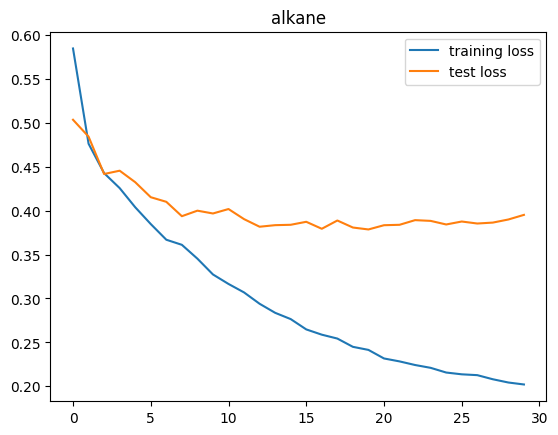

CNN(
  (conv_1): Conv1d(1, 10, kernel_size=(5,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv1d(10, 10, kernel_size=(5,), stride=(1,))
  (pool_2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv1d(10, 10, kernel_size=(5,), stride=(1,))
  (pool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1130, out_features=20, bias=True)
  (linear_2): Linear(in_features=20, out_features=10, bias=True)
  (linear_out): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
#Test to check the model working

crossEnt = torch.nn.BCELoss()
group = 'alkane'

model = train(num_epochs = 30,
              loss_func = crossEnt, 
              group = group,
              data_loaders = func_groups_dataloaders,
              weight_decay = 1e-2,
              lambda_lr = 0.9,
              learning_rate = 5e-3,
              seed = 42,
              plot = True,
              save = False,
              iter = 0,
              save_dirpath = '.') 
model

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 23921


In [13]:
summary = ''

In [14]:
def repeatabilityTest(method: str,
                      loss_func,
                      num_iters: int = 10,
                      num_epochs: int = 30):

    '''
    Test to check the repeatability of the model over all functional groups.

    Parameters
    ----------

    method : str
        Name to distinguish results from each other.
    
    loss_func : Any
        Loss function.
    
    num_iters : int, default 10
        Number of iterations for each functional group.

    num_epochs : int, default 30
        Number of epochs for each model training.
    '''

    for group in smarts.keys():
        
        group_WS = group.replace(' ', '')
        save_dirpath = os.path.join('.', 'results', method, group_WS)

    
        if not os.path.exists(save_dirpath):
            os.makedirs(save_dirpath)
            print("Directory created successfully!")
        else:
            print("Directory already exists!")


        for iteration in range(num_iters):

            start = time.time()

            _, _, func_groups_dataloaders = createHashmaps()

            
            model = train(num_epochs = num_epochs, 
                        loss_func = loss_func, 
                        group = group,
                        data_loaders = func_groups_dataloaders,
                        weight_decay = 1e-2,
                        lambda_lr = 0.9,
                        learning_rate = 1e-3, 
                        seed = 42,
                        plot = True,
                        save = False, 
                        iter = iteration, 
                        save_dirpath = save_dirpath)
            
            print(trainingMetrics(model = model, 
                                   group = group,
                                   data_loaders = func_groups_dataloaders,
                                   iter = iteration,
                                   save_dirpath = save_dirpath))
            
            print(testMetrics(model = model, 
                                group = group,
                                data_loaders = func_groups_dataloaders,
                                iter = iteration,
                                save_dirpath = save_dirpath))
            
            global summary

            print(summary)
            print(f'Time per iteration: {time.time() - start}')

            with open(os.path.join(save_dirpath, 'stats.txt'), 'w') as f:
                f.write(summary)

Directory already exists!


100%|██████████| 15/15 [00:01<00:00,  7.97it/s, accuracy=0.713, epoch=1, f1=0.333, loss=7.33]


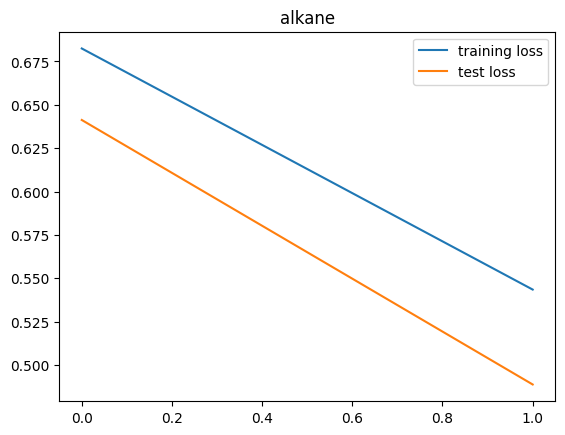

TPR: 71.51%	TNR: 78.85%


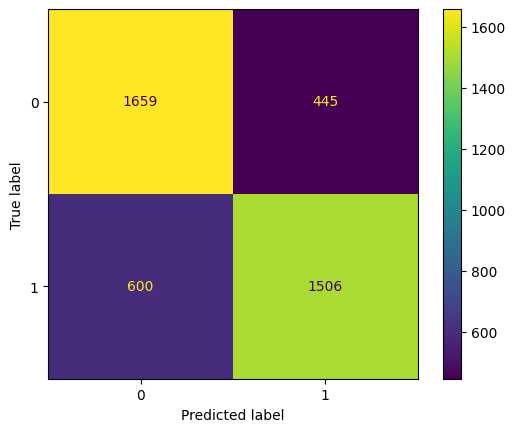

  funcGroup  prediction acc  predicted well  number of groups
0    alkane          0.7151          1506.0            2106.0
TPR: 71.25%	TNR: 80.4%


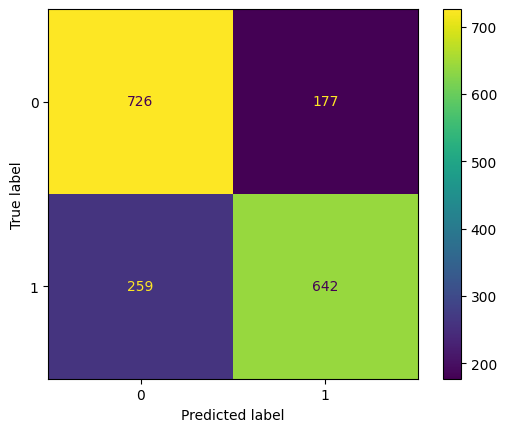

  funcGroup  prediction acc  predicted well  number of groups
0    alkane        0.712542           642.0             901.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%

Time per iteration: 20.578659296035767
Directory already exists!


100%|██████████| 16/16 [00:02<00:00,  7.61it/s, accuracy=0.659, epoch=1, f1=0.673, loss=8.6] 


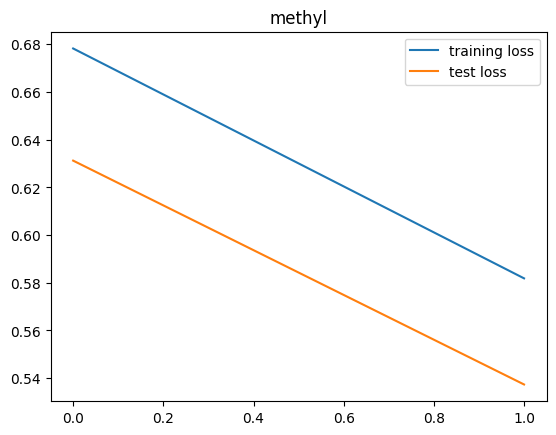

TPR: 66.61%	TNR: 78.64%


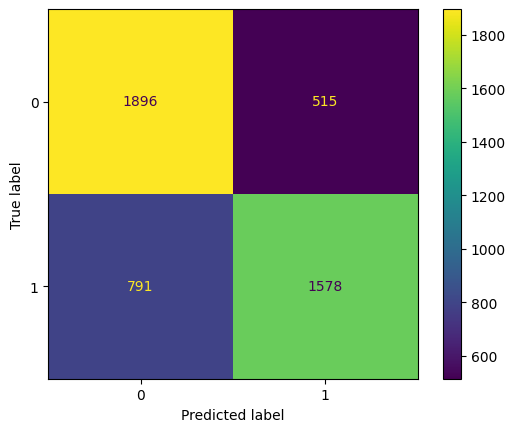

  funcGroup  prediction acc  predicted well  number of groups
0    methyl        0.666104          1578.0            2369.0
TPR: 65.93%	TNR: 79.76%


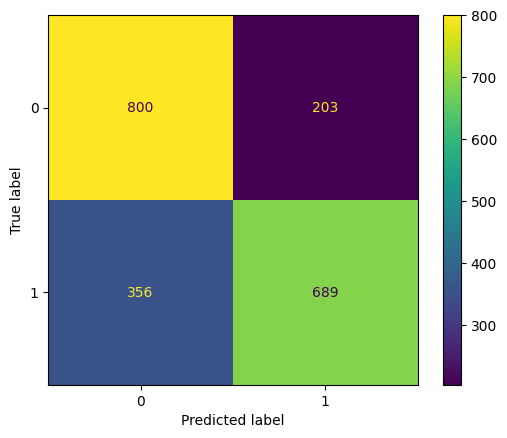

  funcGroup  prediction acc  predicted well  number of groups
0    methyl         0.65933           689.0            1045.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%

Time per iteration: 23.173856735229492
Directory already exists!


100%|██████████| 6/6 [00:00<00:00,  8.09it/s, accuracy=0.496, epoch=1, f1=0.452, loss=4.03]


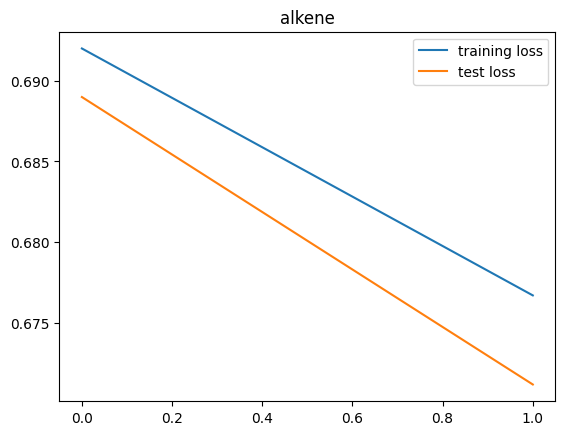

TPR: 52.55%	TNR: 74.51%


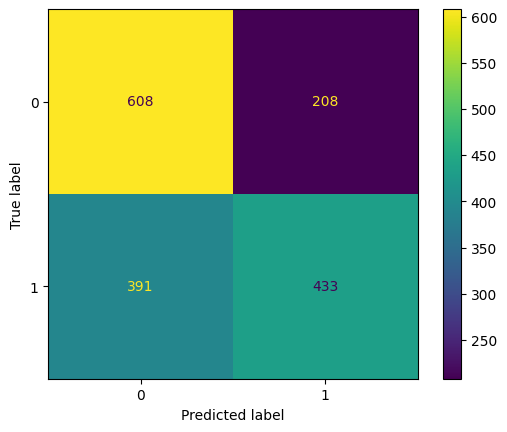

  funcGroup  prediction acc  predicted well  number of groups
0    alkene        0.525485           433.0             824.0
TPR: 49.57%	TNR: 71.83%


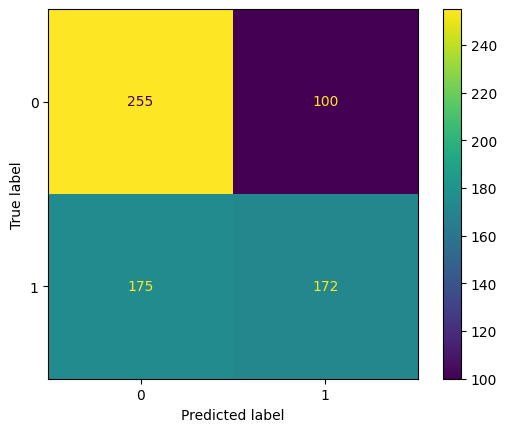

  funcGroup  prediction acc  predicted well  number of groups
0    alkene        0.495677           172.0             347.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%

Time per iteration: 8.441317796707153
Directory already exists!


100%|██████████| 1/1 [00:00<00:00,  8.35it/s, accuracy=0.946, epoch=1, f1=0.721, loss=0.675]


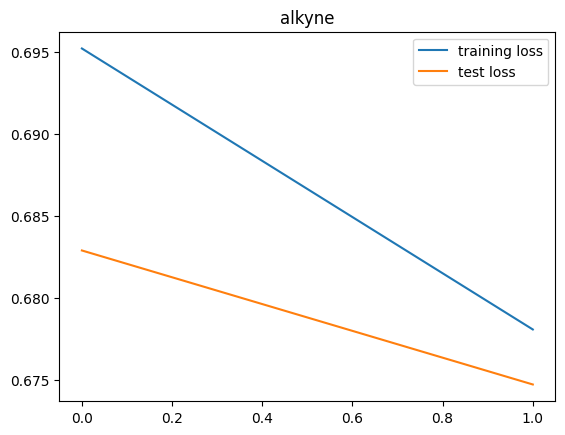

TPR: 85.27%	TNR: 32.31%


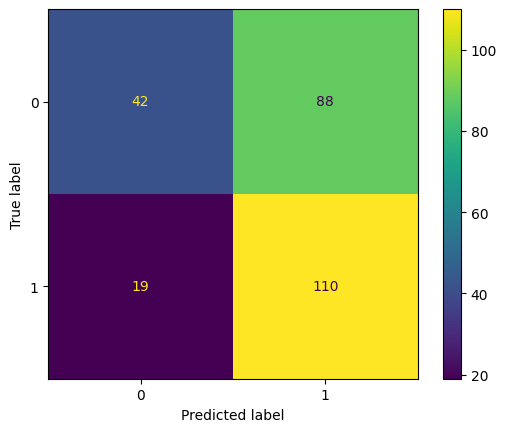

  funcGroup  prediction acc  predicted well  number of groups
0    alkyne        0.852713           110.0             129.0
TPR: 94.64%	TNR: 30.91%


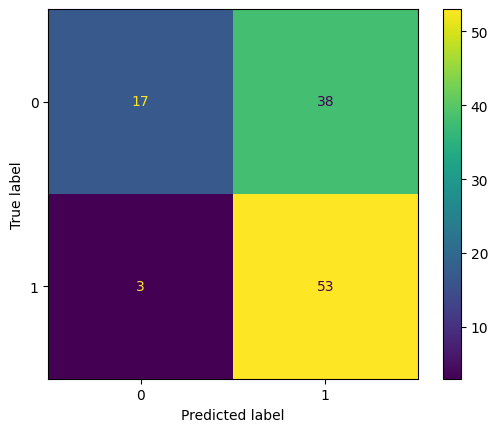

  funcGroup  prediction acc  predicted well  number of groups
0    alkyne        0.946429            53.0              56.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%

Time per iteration: 1.982405662536621
Directory already exists!


100%|██████████| 14/14 [00:01<00:00,  8.11it/s, accuracy=0.751, epoch=1, f1=0, loss=7.96]    


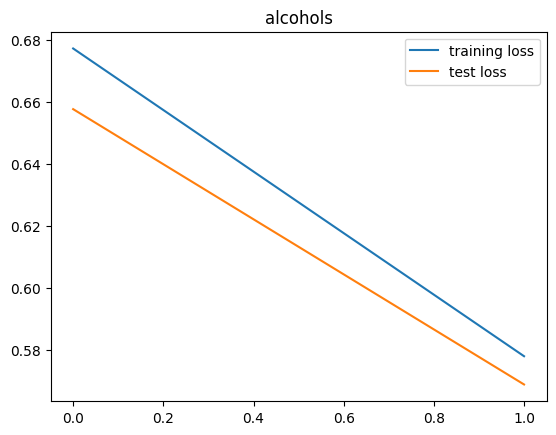

TPR: 75.81%	TNR: 76.88%


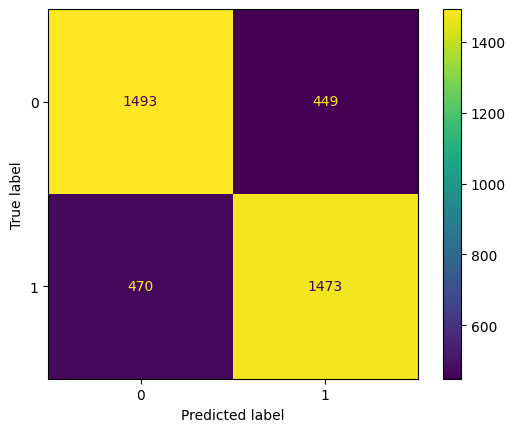

  funcGroup  prediction acc  predicted well  number of groups
0  alcohols        0.758106          1473.0            1943.0
TPR: 75.12%	TNR: 74.91%


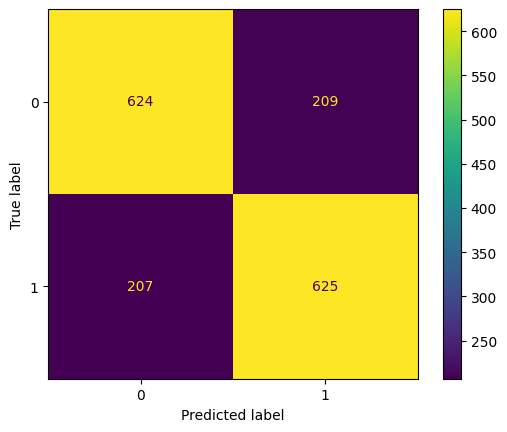

  funcGroup  prediction acc  predicted well  number of groups
0  alcohols        0.751202           625.0             832.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 7/7 [00:00<00:00,  8.16it/s, accuracy=0.616, epoch=1, f1=0.643, loss=4.47] 


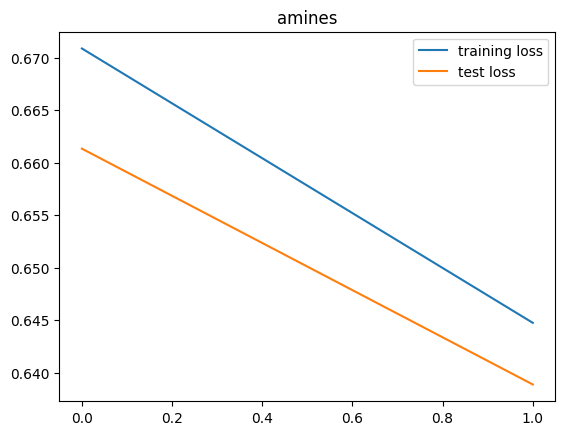

TPR: 60.35%	TNR: 69.12%


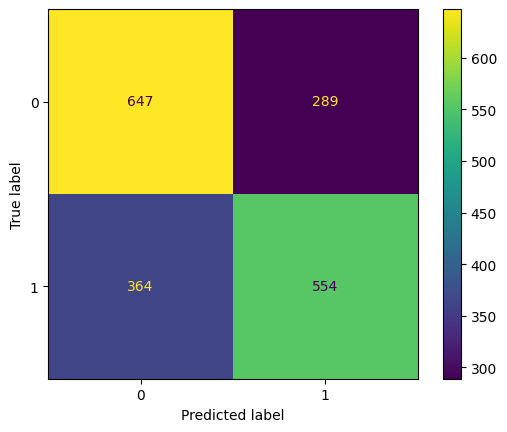

  funcGroup  prediction acc  predicted well  number of groups
0    amines        0.603486           554.0             918.0
TPR: 61.58%	TNR: 67.01%


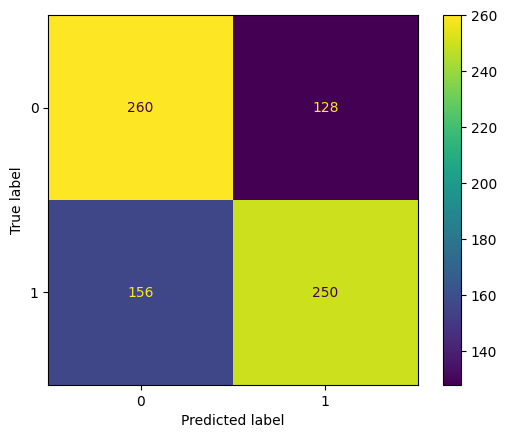

  funcGroup  prediction acc  predicted well  number of groups
0    amines        0.615764           250.0             406.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 2/2 [00:00<00:00,  8.26it/s, accuracy=1, epoch=1, f1=0.635, loss=1.39] 


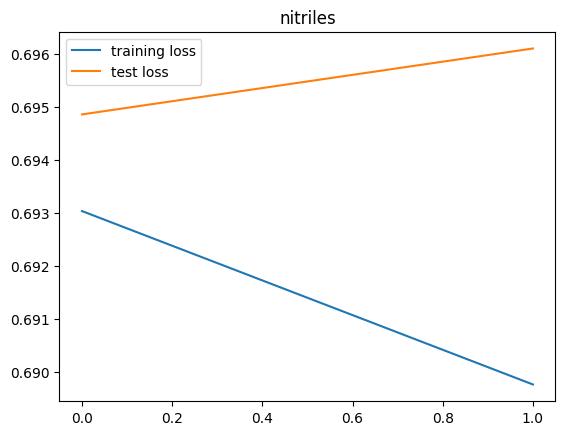

TPR: 100.0%	TNR: 0.0%


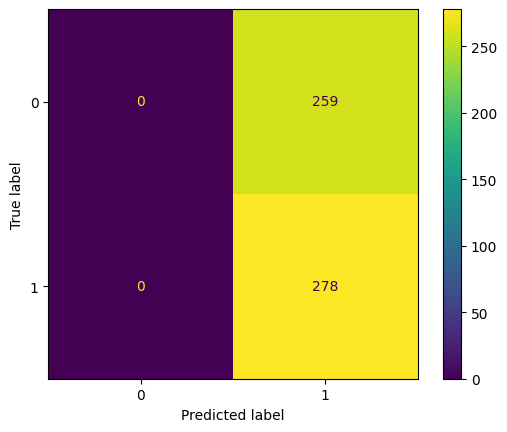

  funcGroup  prediction acc  predicted well  number of groups
0  nitriles             1.0           278.0             278.0
TPR: 100.0%	TNR: 0.0%


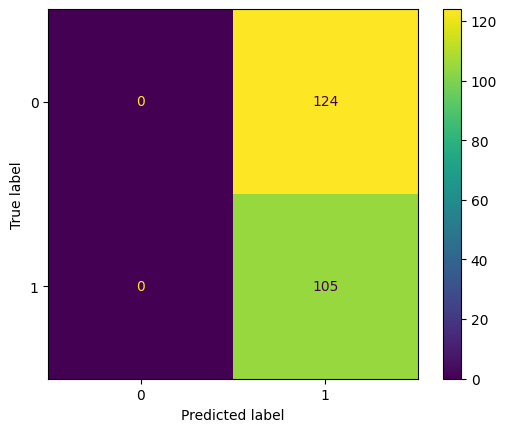

  funcGroup  prediction acc  predicted well  number of groups
0  nitriles             1.0           105.0             105.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 20/20 [00:02<00:00,  7.78it/s, accuracy=0.751, epoch=1, f1=0.737, loss=6.68]


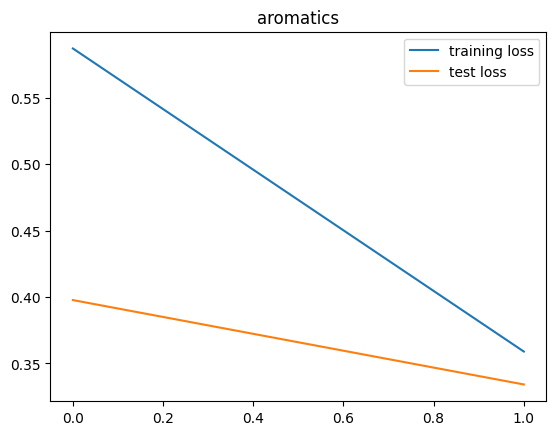

TPR: 75.25%	TNR: 91.36%


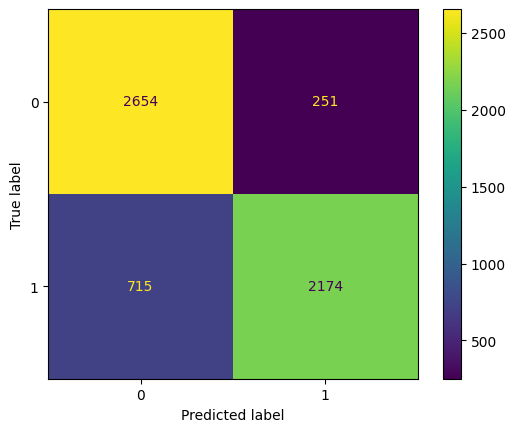

   funcGroup  prediction acc  predicted well  number of groups
0  aromatics         0.75251          2174.0            2889.0
TPR: 75.1%	TNR: 91.57%


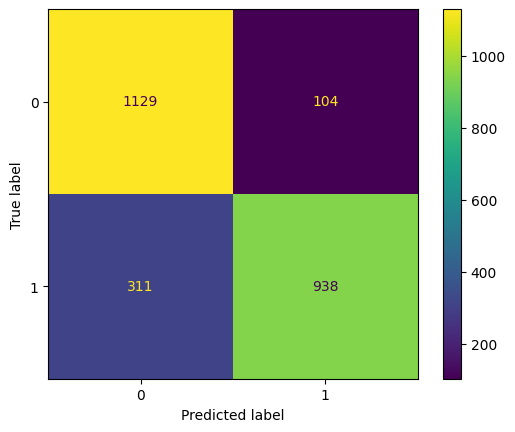

   funcGroup  prediction acc  predicted well  number of groups
0  aromatics        0.751001           938.0            1249.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. 

100%|██████████| 13/13 [00:01<00:00,  7.74it/s, accuracy=0.718, epoch=1, f1=0.732, loss=7.45]


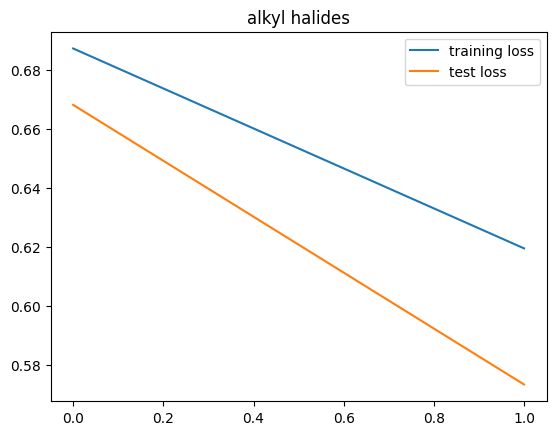

TPR: 72.48%	TNR: 70.59%


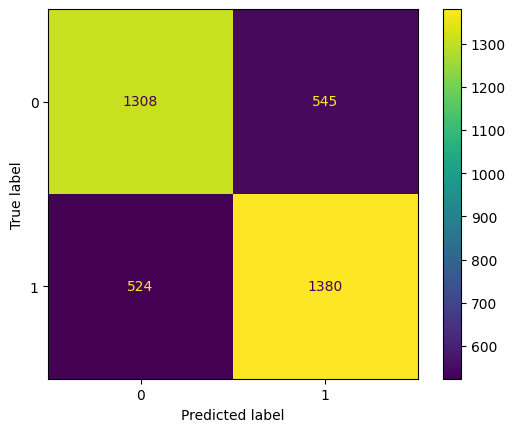

       funcGroup  prediction acc  predicted well  number of groups
0  alkyl halides         0.72479          1380.0            1904.0
TPR: 71.76%	TNR: 66.39%


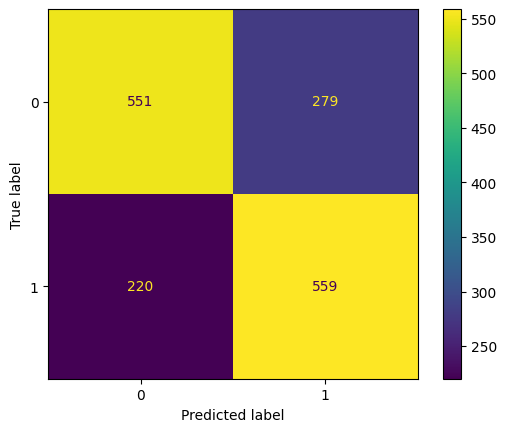

       funcGroup  prediction acc  predicted well  number of groups
0  alkyl halides        0.717587           559.0             779.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 

100%|██████████| 4/4 [00:00<00:00,  7.71it/s, accuracy=0.992, epoch=1, f1=0.785, loss=2.66] 


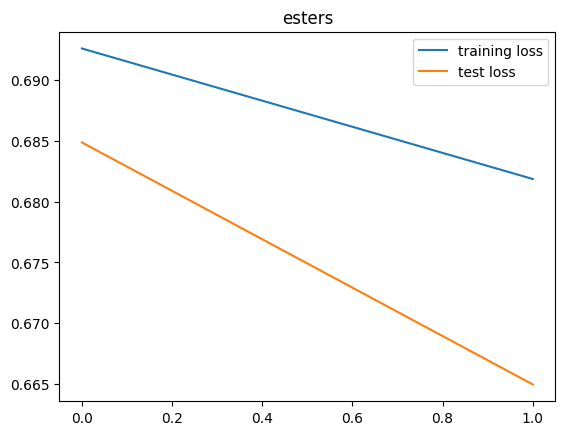

TPR: 99.46%	TNR: 44.89%


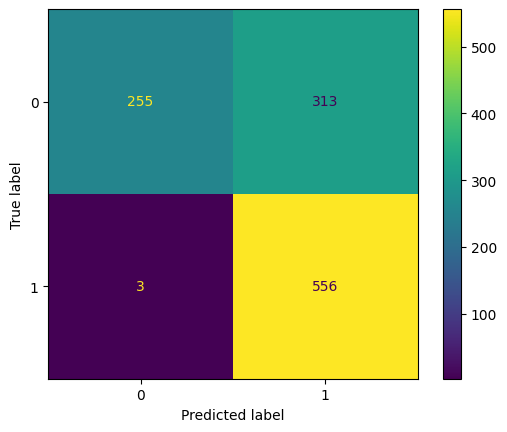

  funcGroup  prediction acc  predicted well  number of groups
0    esters        0.994633           556.0             559.0
TPR: 99.19%	TNR: 45.15%


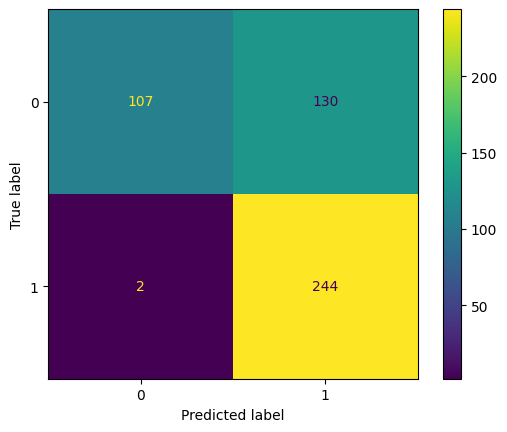

  funcGroup  prediction acc  predicted well  number of groups
0    esters         0.99187           244.0             246.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 3/3 [00:00<00:00,  7.99it/s, accuracy=0.811, epoch=1, f1=0.721, loss=2.02] 


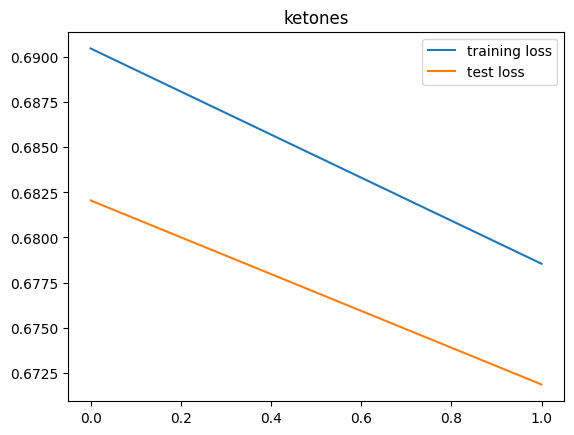

TPR: 78.47%	TNR: 34.64%


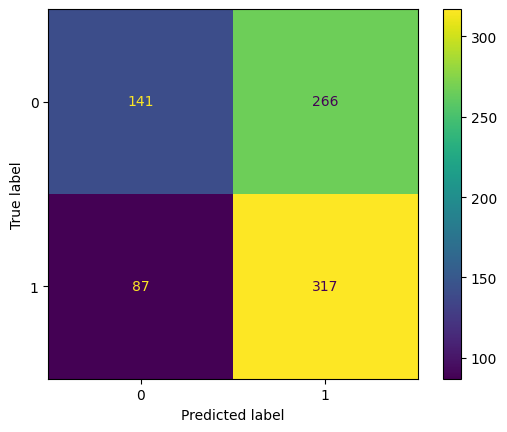

  funcGroup  prediction acc  predicted well  number of groups
0   ketones        0.784653           317.0             404.0
TPR: 81.14%	TNR: 34.3%


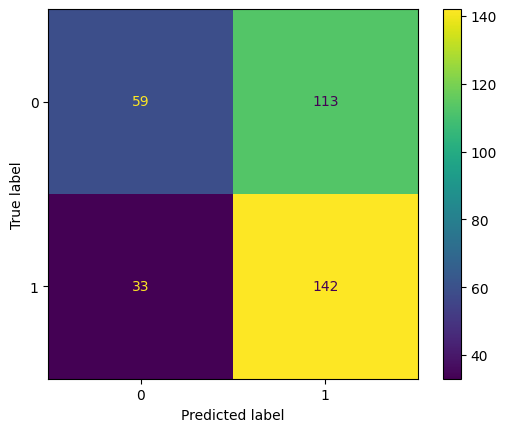

  funcGroup  prediction acc  predicted well  number of groups
0   ketones        0.811429           142.0             175.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 1/1 [00:00<00:00,  7.49it/s, accuracy=0.818, epoch=1, f1=0.621, loss=0.692]


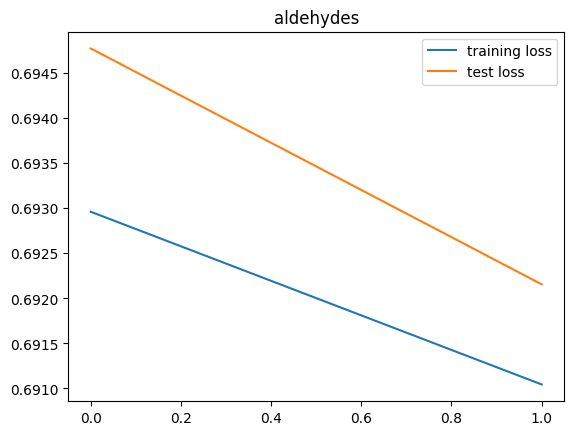

TPR: 80.79%	TNR: 27.54%


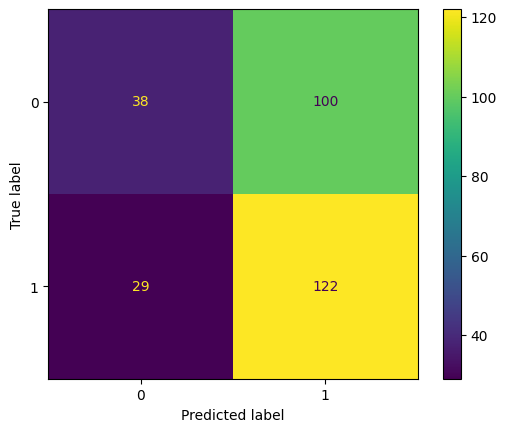

   funcGroup  prediction acc  predicted well  number of groups
0  aldehydes        0.807947           122.0             151.0
TPR: 81.82%	TNR: 33.82%


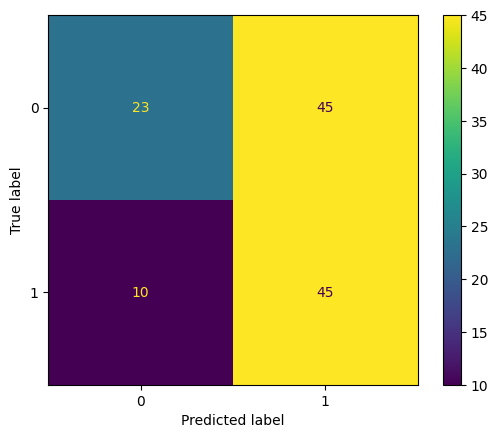

   funcGroup  prediction acc  predicted well  number of groups
0  aldehydes        0.818182            45.0              55.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. 

100%|██████████| 4/4 [00:00<00:00,  8.75it/s, accuracy=0.884, epoch=1, f1=0.833, loss=2.61]


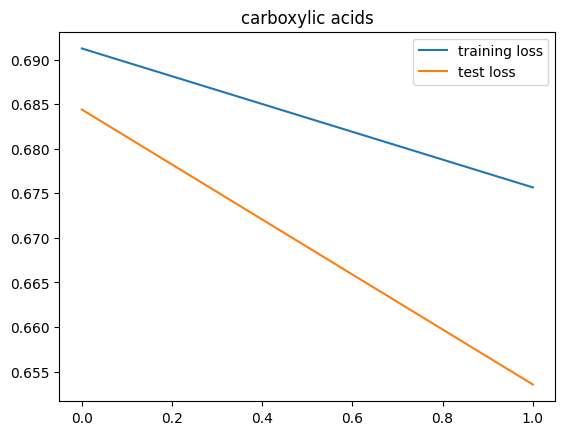

TPR: 84.49%	TNR: 86.12%


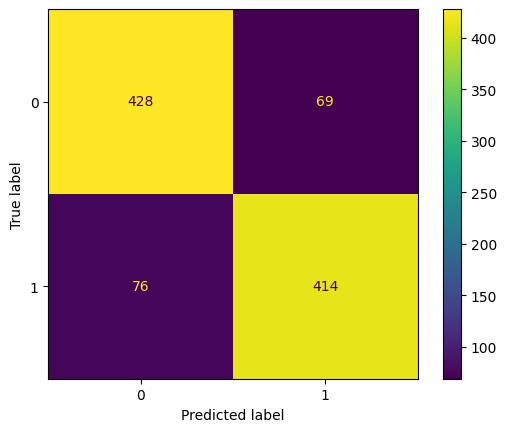

          funcGroup  prediction acc  predicted well  number of groups
0  carboxylic acids        0.844898           414.0             490.0
TPR: 88.37%	TNR: 87.98%


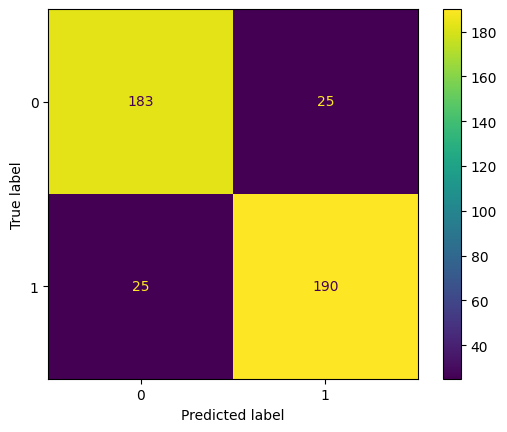

          funcGroup  prediction acc  predicted well  number of groups
0  carboxylic acids        0.883721           190.0             215.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iter

100%|██████████| 9/9 [00:01<00:00,  7.44it/s, accuracy=0.705, epoch=1, f1=0.721, loss=5.76]


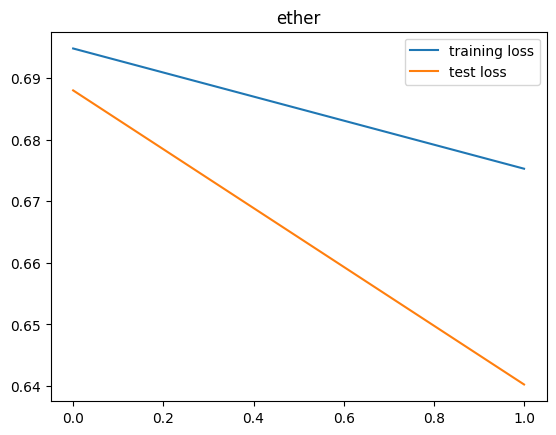

TPR: 66.62%	TNR: 85.57%


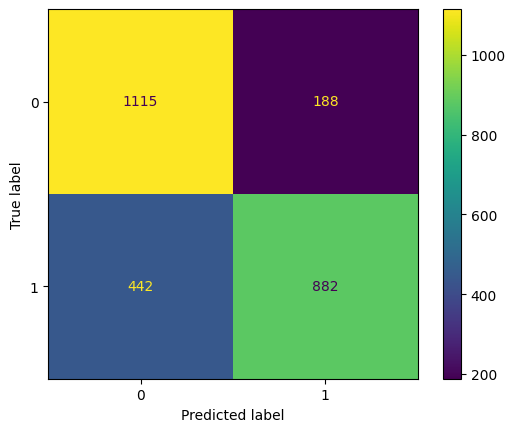

  funcGroup  prediction acc  predicted well  number of groups
0     ether        0.666163           882.0            1324.0
TPR: 70.47%	TNR: 82.72%


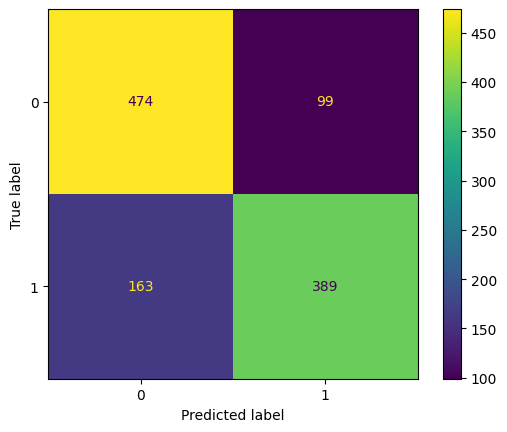

  funcGroup  prediction acc  predicted well  number of groups
0     ether         0.70471           389.0             552.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 1/1 [00:00<00:00, 15.50it/s, accuracy=0, epoch=1, f1=0, loss=0.686]


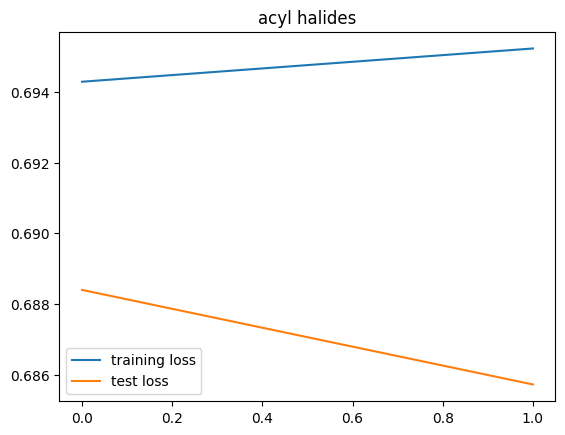

TPR: 0.0%	TNR: 100.0%


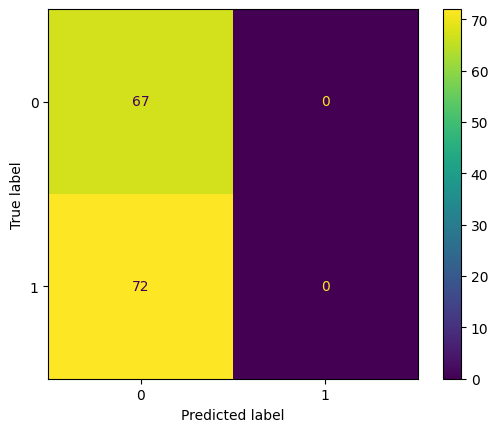

      funcGroup  prediction acc  predicted well  number of groups
0  acyl halides             0.0             0.0              72.0
TPR: 0.0%	TNR: 100.0%


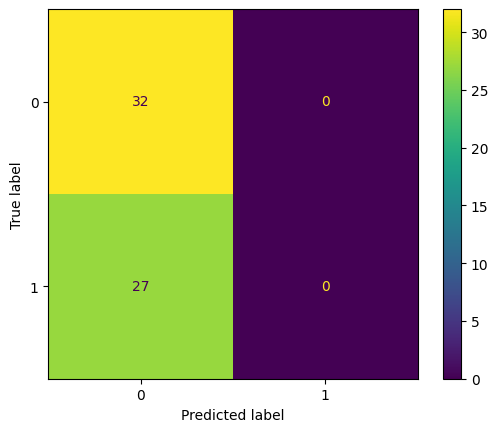

      funcGroup  prediction acc  predicted well  number of groups
0  acyl halides             0.0             0.0              27.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 

100%|██████████| 1/1 [00:00<00:00,  8.45it/s, accuracy=1, epoch=1, f1=0.65, loss=0.689]


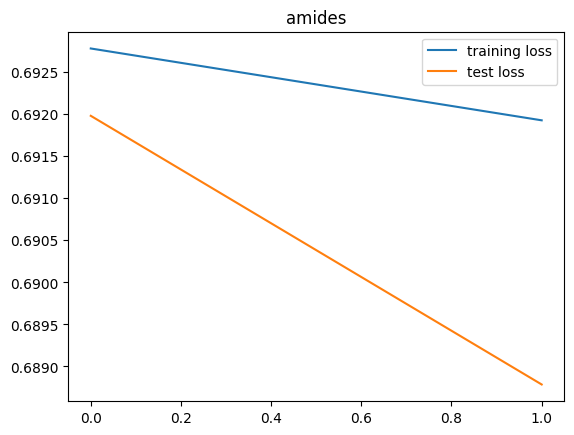

TPR: 100.0%	TNR: 0.8%


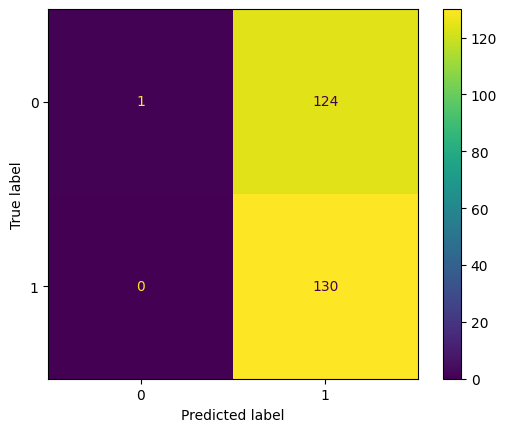

  funcGroup  prediction acc  predicted well  number of groups
0    amides             1.0           130.0             130.0
TPR: 100.0%	TNR: 1.75%


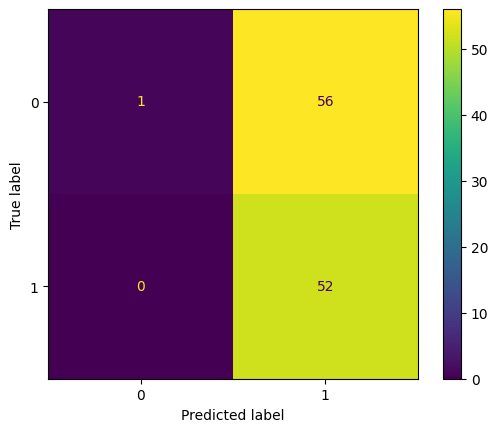

  funcGroup  prediction acc  predicted well  number of groups
0    amides             1.0            52.0              52.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 3/3 [00:00<00:00,  7.95it/s, accuracy=0, epoch=1, f1=0, loss=2.07] 


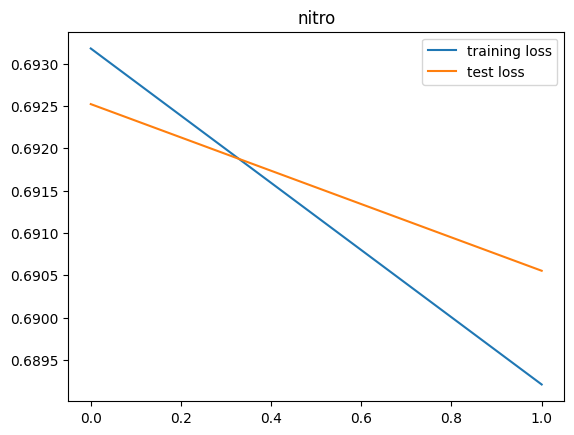

TPR: 0.0%	TNR: 100.0%


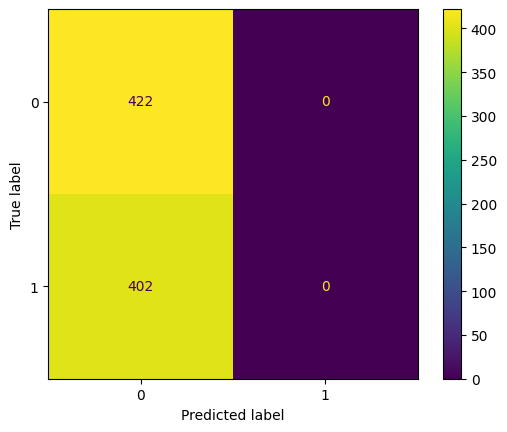

  funcGroup  prediction acc  predicted well  number of groups
0     nitro             0.0             0.0             402.0
TPR: 0.0%	TNR: 100.0%


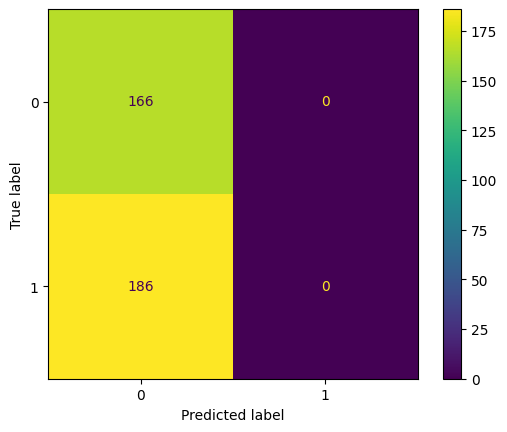

  funcGroup  prediction acc  predicted well  number of groups
0     nitro             0.0             0.0             186.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

100%|██████████| 10/10 [00:01<00:00,  7.78it/s, accuracy=0.608, epoch=1, f1=0.629, loss=6.49]


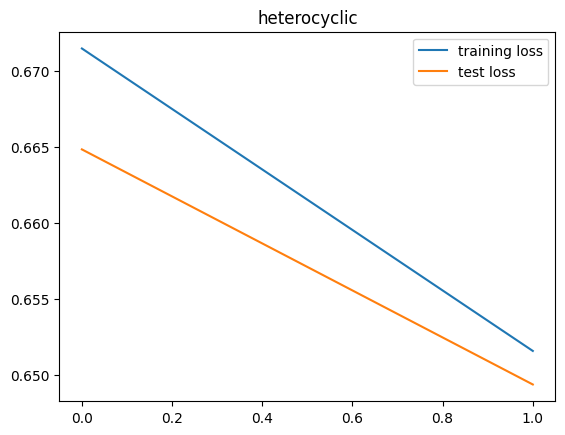

TPR: 63.62%	TNR: 65.64%


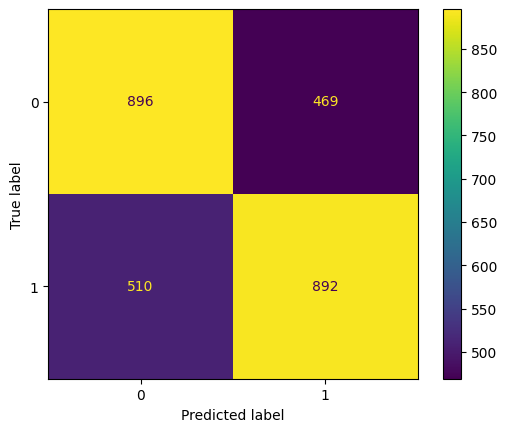

      funcGroup  prediction acc  predicted well  number of groups
0  heterocyclic        0.636234           892.0            1402.0
TPR: 60.8%	TNR: 64.16%


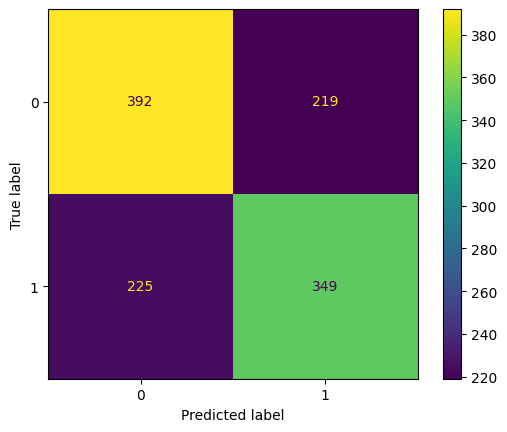

      funcGroup  prediction acc  predicted well  number of groups
0  heterocyclic        0.608014           349.0             574.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 

100%|██████████| 5/5 [00:00<00:00,  8.50it/s, accuracy=0.791, epoch=1, f1=0.4, loss=3.34]   


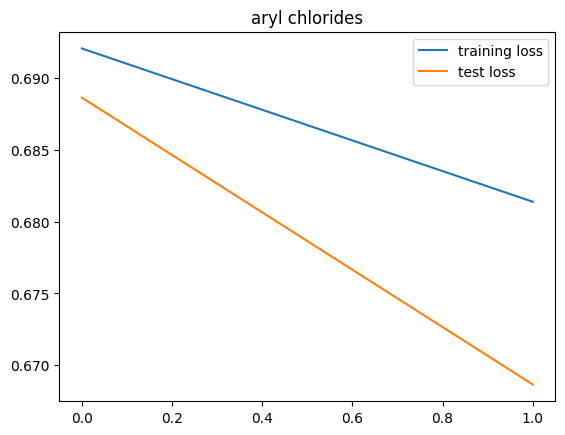

TPR: 79.15%	TNR: 54.14%


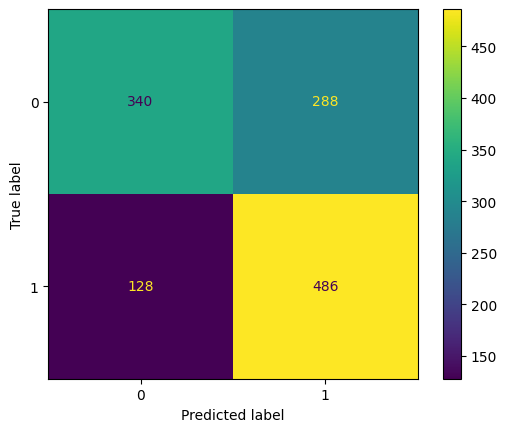

        funcGroup  prediction acc  predicted well  number of groups
0  aryl chlorides        0.791531           486.0             614.0
TPR: 79.12%	TNR: 54.83%


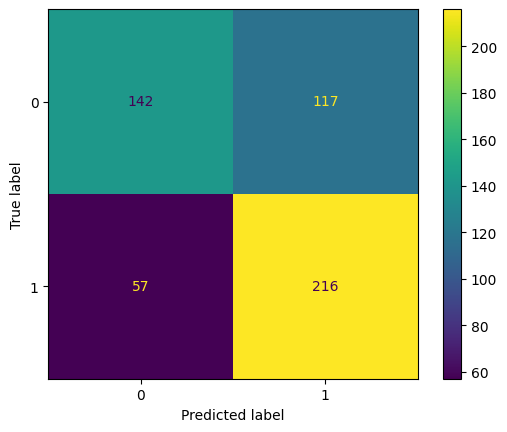

        funcGroup  prediction acc  predicted well  number of groups
0  aryl chlorides        0.791209           216.0             273.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteratio

100%|██████████| 4/4 [00:00<00:00,  8.43it/s, accuracy=1, epoch=1, f1=0.765, loss=2.73]


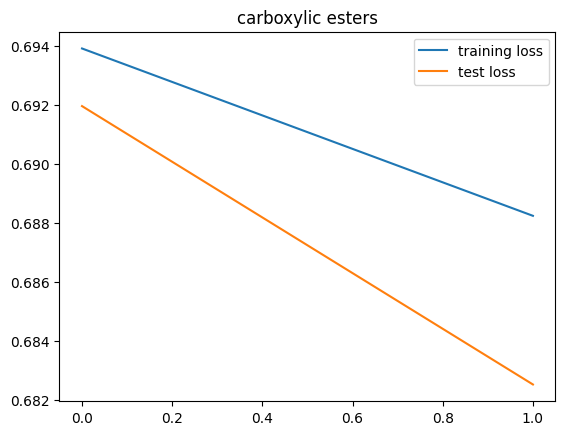

TPR: 99.63%	TNR: 40.83%


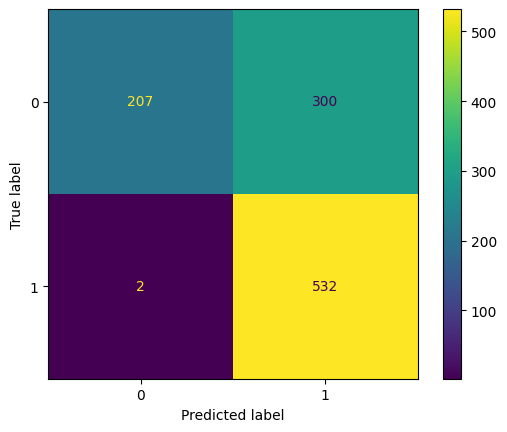

           funcGroup  prediction acc  predicted well  number of groups
0  carboxylic esters        0.996255           532.0             534.0
TPR: 100.0%	TNR: 41.53%


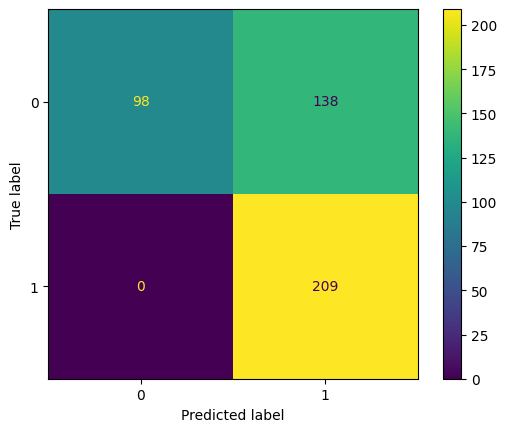

           funcGroup  prediction acc  predicted well  number of groups
0  carboxylic esters             1.0           209.0             209.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
It

100%|██████████| 3/3 [00:00<00:00,  8.20it/s, accuracy=0.792, epoch=1, f1=0.667, loss=2.01] 


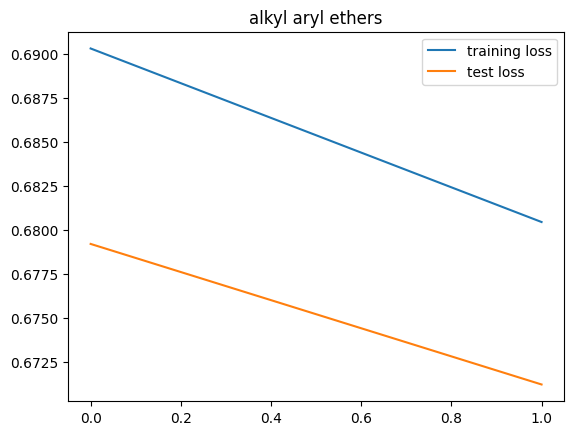

TPR: 81.28%	TNR: 49.74%


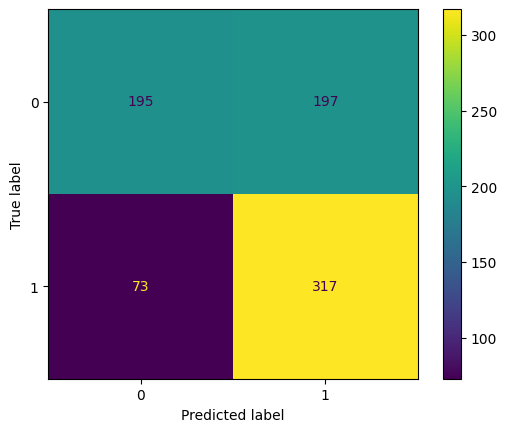

           funcGroup  prediction acc  predicted well  number of groups
0  alkyl aryl ethers        0.812821           317.0             390.0
TPR: 79.17%	TNR: 52.41%


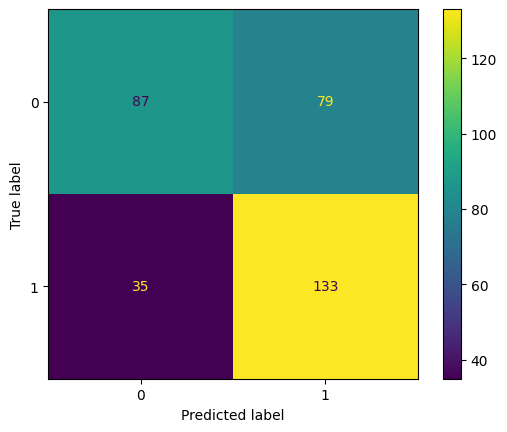

           funcGroup  prediction acc  predicted well  number of groups
0  alkyl aryl ethers        0.791667           133.0             168.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
It

100%|██████████| 3/3 [00:00<00:00,  7.42it/s, accuracy=0.484, epoch=1, f1=0.578, loss=1.99]


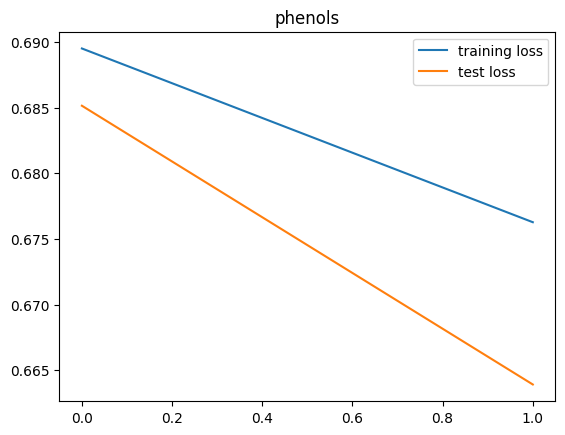

TPR: 48.46%	TNR: 67.22%


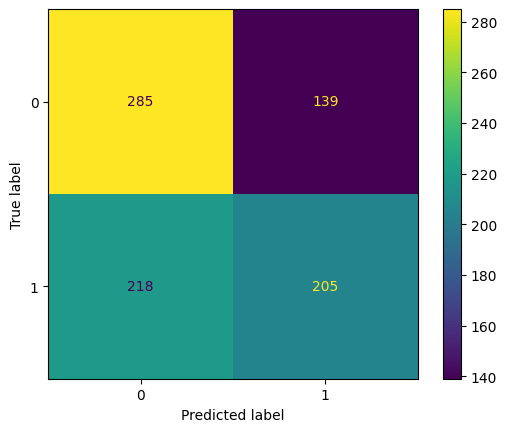

  funcGroup  prediction acc  predicted well  number of groups
0   phenols        0.484634           205.0             423.0
TPR: 48.35%	TNR: 65.19%


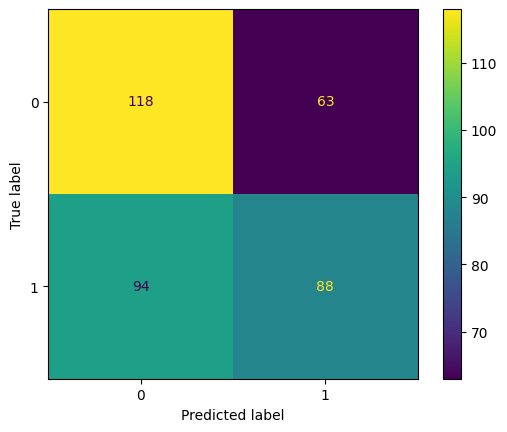

  funcGroup  prediction acc  predicted well  number of groups
0   phenols        0.483516            88.0             182.0
Iteration 0 training. Group alkane. EM: 1506 1659 445 600 TPR: 71.51%	TNR: 78.85%	accuracy: 75.18%
Iteration 0 test. Group alkane. EM: 642 726 177 259 TPR: 71.25%	TNR: 80.4%	accuracy: 75.83%
Iteration 0 training. Group methyl. EM: 1578 1896 515 791 TPR: 66.61%	TNR: 78.64%	accuracy: 72.68%
Iteration 0 test. Group methyl. EM: 689 800 203 356 TPR: 65.93%	TNR: 79.76%	accuracy: 72.71%
Iteration 0 training. Group alkene. EM: 433 608 208 391 TPR: 52.55%	TNR: 74.51%	accuracy: 63.48%
Iteration 0 test. Group alkene. EM: 172 255 100 175 TPR: 49.57%	TNR: 71.83%	accuracy: 60.83%
Iteration 0 training. Group alkyne. EM: 110 42 88 19 TPR: 85.27%	TNR: 32.31%	accuracy: 58.69%
Iteration 0 test. Group alkyne. EM: 53 17 38 3 TPR: 94.64%	TNR: 30.91%	accuracy: 63.06%
Iteration 0 training. Group alcohols. EM: 1473 1493 449 470 TPR: 75.81%	TNR: 76.88%	accuracy: 76.34%
Iteration 0 test. Gr

In [15]:
#Test to check the method working

crossEnt = torch.nn.BCELoss()

repeatabilityTest(method = 'conv30VIII',
                  loss_func = crossEnt,
                  num_iters = 1,
                  num_epochs = 2)